# `007` Initialization

Requirements: 006 Pytorch

When stacking many layers, it's easy to run into numerical stability problems pretty fast. Consider a function like ReLU, that zeroes out negative numbers but leaves positive numbers unchanged. If large weights get stacked on top of each other, the output can easily become `inf` or `nan`. This is particularly dangerous during the first few iterations, when the weights are initialized randomly.

In 2015, [Kaiming He et al.](https://arxiv.org/abs/1502.01852v1) proposed a simple and effective way to initialize the weights of deep neural networks. The idea is to initialize the weights with a normal distribution, but scale the variance with the number of inputs to the neuron. This way, the variance of the input and output of each layer is roughly the same, which helps to keep the signal from exploding or vanishing.

In [1]:
import torchvision
import matplotlib.pyplot as plt
import torch

In [2]:
# let's say we have a three layers with normal distribution stacked together
x = torch.randn(784)
layer1 = torch.randn(784, 256)
layer2 = torch.randn(256, 128)
layer3 = torch.randn(128, 10)

print(f'Input data mean: {x.mean()}, std: {x.std()}')
x = (x @ layer1).relu()
print(f'After layer1 mean: {x.mean()}, std: {x.std()}')
x = (x @ layer2).relu()
print(f'After layer2 mean: {x.mean()}, std: {x.std()}')
x = (x @ layer3).relu()
print(f'After layer3 mean: {x.mean()}, std: {x.std()}')

Input data mean: -0.040285874158144, std: 0.9817079305648804
After layer1 mean: 10.838348388671875, std: 15.53577709197998
After layer2 mean: 101.06379699707031, std: 158.8281707763672
After layer3 mean: 1004.1019287109375, std: 864.0884399414062


As we pass the signals down the network, the mean and variance grow with each layer even though we are using random data with a normal distribution.

The idea Kaiming proposed was: taking a normal distribution, passing it through some activation function and figuring out what was its variance. Then, we could scale the weights of the layer by the inverse of that variance. This way, the variance of the input and output of each layer is roughly the same, which helps to keep the signal from exploding or vanishing.

In the case of ReLU, the variance of the output is `2/n`, where `n` is the number of inputs. So, we scale the weights by `sqrt(2/n)`, which is the standard deviation.

In [3]:
# let's say we have a three layers with normal distribution stacked together, now with kaiming initialization
x = torch.randn(784)
layer1 = torch.randn(784, 256) * (2 / 784) ** .5
layer2 = torch.randn(256, 128) * (2 / 256) ** .5
layer3 = torch.randn(128, 10) * (2 / 128) ** .5

print(f'Input data mean: {x.mean()}, std: {x.std()}')
x = (x @ layer1).relu()
print(f'After layer1 mean: {x.mean()}, std: {x.std()}')
x = (x @ layer2).relu()
print(f'After layer2 mean: {x.mean()}, std: {x.std()}')
x = (x @ layer3).relu()
print(f'After layer3 mean: {x.mean()}, std: {x.std()}')

Input data mean: -0.0050872014835476875, std: 0.9993767142295837
After layer1 mean: 0.556320309638977, std: 0.8295928239822388
After layer2 mean: 0.4753851294517517, std: 0.7226547002792358
After layer3 mean: 0.9290803670883179, std: 1.0775606632232666


Now all the standard deviations are similar, and the signal doesn't explode or vanish. It's important to note that, if we use an activation function other than ReLU, we need to adjust the scaling factor accordingly.

Finally, let's test training a network with and without optimizing the input.

In [4]:
train = torchvision.datasets.MNIST(root='data', download=True)
test = torchvision.datasets.MNIST(root='data', download=True, train=False)
x = train.data.view(-1, 28 * 28).float()
xt = test.data.view(-1, 28 * 28).float()
y = torch.nn.functional.one_hot(train.targets).float()
yt = torch.nn.functional.one_hot(test.targets).float()

In [5]:
def get_model(hidden_size=128):
	W1 = torch.randn(784, hidden_size)
	b1 = torch.zeros(hidden_size)
	W2 = torch.randn(hidden_size, hidden_size)
	b2 = torch.zeros(hidden_size)
	W3 = torch.randn(hidden_size, hidden_size)
	b3 = torch.zeros(hidden_size)
	W4 = torch.randn(hidden_size, 10)
	b4 = torch.zeros(10)
	parameters = W1, b1, W2, b2, W3, b3, W4, b4
	for p in parameters:
		p.requires_grad = True
	return parameters

def forward(model, x):
	W1, b1, W2, b2, W3, b3, W4, b4 = model
	x = x @ W1 + b1
	x = x.relu()
	x = x @ W2 + b2
	x = x.relu()
	x = x @ W3 + b3
	x = x.relu()
	x = x @ W4 + b4
	return x

Iteration    0, loss: 0.168750
Iteration  200, loss: 0.187500
Iteration  400, loss: 0.200000
Iteration  600, loss: 0.193750
Iteration  800, loss: 0.187500
Accuracy on the test set: 11.30%


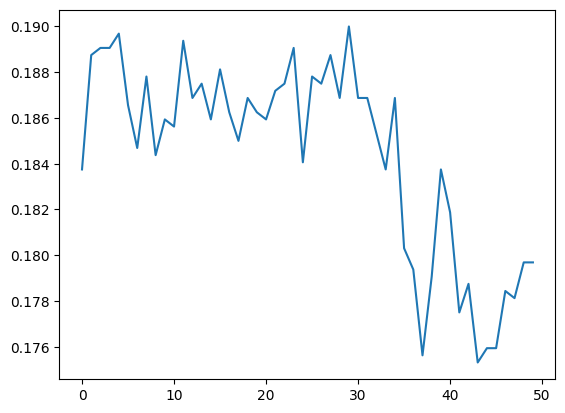

In [6]:
def train(model, iterations=1000, batch_size=32, lr=.01, lr_decay=0.999):
	torch.manual_seed(1234)
	losses = []
	for i in range(iterations):
		ix = torch.randint(0, x.shape[0], (batch_size,))
		xb, yb = x[ix], y[ix]
		logits = forward(model, xb)
		ypred = logits.softmax(dim=1)
		loss = ((ypred - yb)**2).mean()
		for p in model: p.grad = None
		loss.backward()
		for p in model:
			p.data -= p.grad * lr * lr_decay**i
		losses.append(loss.item())
		if i % 200 == 0:
			print(f'Iteration {i:4}, loss: {loss.item():.6f}')
	plt.plot(torch.tensor(losses).view(-1, 20).mean(dim=1))  # average the loss over 20 iterations
	accuracy = (forward(model, xt).argmax(dim=1) == yt.argmax(dim=1)).float().mean().item()
	print(f'Accuracy on the test set: {100 * accuracy:.2f}%')

model = get_model()
train(model)

As we expected, it suffices to stack a few layers for the loss to explode. Let's now try with a proper initialization.

Iteration    0, loss: 0.150886
Iteration  200, loss: 0.131237
Iteration  400, loss: 0.154789
Iteration  600, loss: 0.122177
Iteration  800, loss: 0.137500
Accuracy on the test set: 44.45%


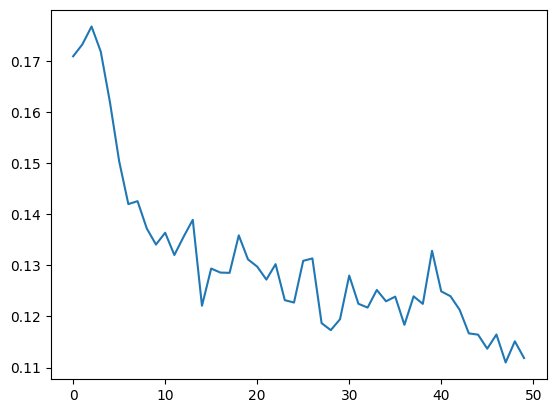

In [7]:
def get_model(hidden_size=128):
	W1 = torch.randn(784, hidden_size) * (2 / 784) ** .5
	b1 = torch.zeros(hidden_size)
	W2 = torch.randn(hidden_size, hidden_size) * (2 / hidden_size) ** .5
	b2 = torch.zeros(hidden_size)
	W3 = torch.randn(hidden_size, hidden_size) * (2 / hidden_size) ** .5
	b3 = torch.zeros(hidden_size)
	W4 = torch.randn(hidden_size, 10) * (2 / hidden_size) ** .5
	b4 = torch.zeros(10)
	parameters = W1, b1, W2, b2, W3, b3, W4, b4
	for p in parameters:
		p.requires_grad = True
	return parameters

model = get_model()
train(model)

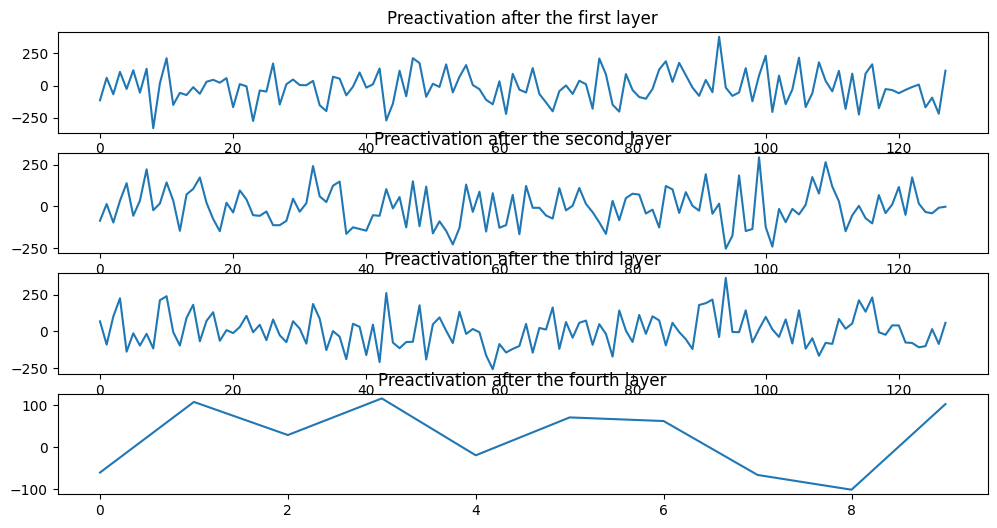

In [8]:
W1, b1, W2, b2, W3, b3, W4, b4 = model
plt.figure(figsize=(12, 6))

signal = (x[0] @ W1 + b1)
plt.subplot(4, 1, 1)
plt.plot(signal.detach().numpy())
plt.title('Preactivation after the first layer')

signal = signal.relu()
signal = signal @ W2 + b2
plt.subplot(4, 1, 2)
plt.plot(signal.detach().numpy())
plt.title('Preactivation after the second layer')

signal = signal.relu()
signal = signal @ W3 + b3
plt.subplot(4, 1, 3)
plt.plot(signal.detach().numpy())
plt.title('Preactivation after the third layer')

signal = signal.relu()
signal = signal @ W4 + b4
plt.subplot(4, 1, 4)
plt.plot(signal.detach().numpy())
plt.title('Preactivation after the fourth layer');

One reason why a proper initialization is not enough for our network to learn is that we have many **dead neurons**. If you look at all **preactivations** (signal before the ReLU), you'll see many neurons outputting a very negative number. Since negative numbers are zeroed out later by ReLU, when we compute the gradients of these cells, they are zero. This is a problem because the weights of these neurons will never be updated, and they will remain dead forever.

There are a few ways to solve that problem, such as using activation functions that don't fully zero out negative numbers, or using **batch normalization**, which is covered in a subsequent notebook. Let's try to use the GELU activation function, also taking into account that we need to adjust the initialization.

Iteration    0, loss: 0.150721
Iteration  200, loss: 0.129853
Iteration  400, loss: 0.162395
Iteration  600, loss: 0.131210
Iteration  800, loss: 0.145394
Accuracy on the test set: 33.27%


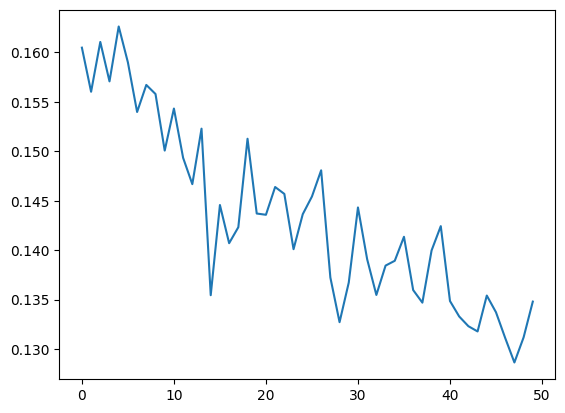

In [9]:
def forward(model, x):
	W1, b1, W2, b2, W3, b3, W4, b4 = model
	x = x @ W1 + b1
	x = torch.nn.functional.gelu(x)
	x = x @ W2 + b2
	x = torch.nn.functional.gelu(x)
	x = x @ W3 + b3
	x = torch.nn.functional.gelu(x)
	x = x @ W4 + b4
	return x

model = get_model()
train(model)